Simulation CSV generated: simulations.csv
Graph CSV generated: graph.csv
Graph loaded with 17 nodes and 19 edges.
Simulations loaded from 'simulations.csv': 10 initial, 9 valid.
Simulating routes based on the CSV file...
Simulation complete. Edge probabilities calculated.
Dirichlet distribution applied to edge probabilities.


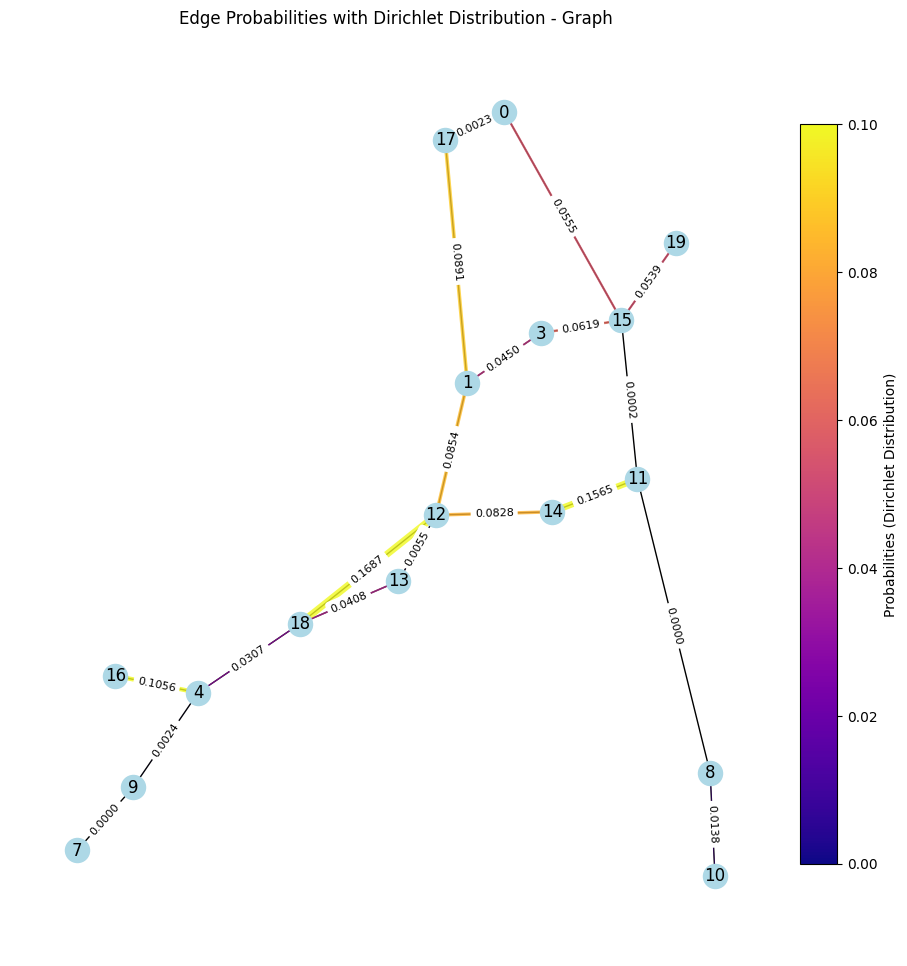

Restricted edges:
(0, 17)
(7, 9)
(4, 9)
(8, 11)
(11, 15)


In [4]:
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import numpy as np

class TruckRoutingSimulationFromCSV:
    def __init__(self, graph_csv, simulation_csv, dirichlet_alpha=1e-5):
        self.graph_csv = graph_csv
        self.simulation_csv = simulation_csv
        self.alpha = dirichlet_alpha
        self.G = None
        self.edge_probabilities = None
        self.simulation_data = None

    def load_graph_from_csv(self):
        """Loads the graph from a CSV file containing edges and their weights,
           and adds inverse edges to make it bidirectional."""
        data = pd.read_csv(self.graph_csv)
        data['source'] = data['source'].astype(int)  # Explicit conversion to integer
        data['target'] = data['target'].astype(int)  # Explicit conversion to integer
        data['weight'] = data['weight'].astype(int)  # Explicit conversion of weights to integer
        self.G = nx.Graph()

        # Add edges and make the graph bidirectional
        for _, row in data.iterrows():
            source = row['source']
            target = row['target']
            weight = row['weight']
            self.G.add_edge(source, target, weight=weight)

            # Add the inverse edge for bidirectionality
            if not self.G.has_edge(target, source):
                self.G.add_edge(target, source, weight=weight)

        print(f"Graph loaded with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges.")

    def load_simulation_data(self, simulation_file="simulations.csv"):
        """Loads simulation data from a CSV file."""
        self.simulation_data = pd.read_csv(simulation_file)
        
        # Filter the simulations to keep only the nodes present in the graph
        valid_nodes = set(self.G.nodes)
        initial_count = len(self.simulation_data)
        self.simulation_data = self.simulation_data[
            (self.simulation_data['start_node'].isin(valid_nodes)) & 
            (self.simulation_data['end_node'].isin(valid_nodes))
        ]
        filtered_count = len(self.simulation_data)
        
        print(f"Simulations loaded from '{simulation_file}': {initial_count} initial, {filtered_count} valid.")

    def simulate_truck_routes_from_csv(self):
        """Simulates truck routes using the start and end node data from the CSV."""
        if not self.G:
            raise ValueError("The graph has not been loaded. Call load_graph_from_csv() first.")
        if self.simulation_data is None:
            raise ValueError("Simulation data has not been loaded. Call load_simulation_data() first.")

        # Normalize the edges of the graph (by sorting nodes)
        edge_counts = {tuple(sorted(edge)): 0 for edge in self.G.edges}
        print(f"Simulating routes based on the CSV file...")

        for _, row in self.simulation_data.iterrows():
            start_node = row['start_node']
            end_node = row['end_node']
            path = self.random_walk(start_node, end_node)

            for i in range(len(path) - 1):
                # Create the edge by sorting the nodes to ensure consistency
                edge = tuple(sorted((path[i], path[i + 1])))
                # Check if the edge exists in the graph
                if edge in edge_counts:
                    edge_counts[edge] += 1
                else:
                    print(f"Warning: the edge {edge} does not exist in the graph and is ignored.")

        # Normalize the counts into probabilities
        self.edge_probabilities = {edge: count / len(self.simulation_data) for edge, count in edge_counts.items()}
        print("Simulation complete. Edge probabilities calculated.")

    def random_walk(self, start_node, end_node, max_steps=50):
        """Performs a random walk between start_node and end_node."""
        path = [start_node]
        current_node = start_node
        steps = 0

        while current_node != end_node and steps < max_steps:
            neighbors = list(self.G.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            path.append(next_node)
            current_node = next_node
            steps += 1

        return path

    def apply_dirichlet_distribution(self):
        """Applies a Dirichlet distribution to the edge probabilities."""
        if not self.edge_probabilities:
            raise ValueError("Edge probabilities have not been calculated.")
        
        alpha = np.array(list(self.edge_probabilities.values())) + self.alpha
        dirichlet_sample = dirichlet.rvs(alpha, size=1)[0]
        self.edge_probabilities = {edge: prob for edge, prob in zip(self.edge_probabilities.keys(), dirichlet_sample)}
        print("Dirichlet distribution applied to edge probabilities.")

    def visualize_graph(self):
        """Visualizes the graph with edge probabilities."""
        if not self.edge_probabilities:
            raise ValueError("Edge probabilities have not been calculated or updated.")

        pos = nx.spring_layout(self.G, seed=42)  # Layout for visualization
        probabilities = list(self.edge_probabilities.values())
        norm = plt.Normalize(vmin=0, vmax=0.1)
        cmap = plt.cm.plasma

        fig, ax = plt.subplots(figsize=(12, 12))
        nx.draw(self.G, pos, with_labels=True, node_color="lightblue", node_size=300, ax=ax)

        for edge, prob in self.edge_probabilities.items():
            color = cmap(norm(prob))
            nx.draw_networkx_edges(
                self.G, pos, edgelist=[edge], width=5 * prob / max(probabilities), edge_color=[color], alpha=0.8, ax=ax
            )

        edge_labels = {edge: f"{prob:.4f}" for edge, prob in self.edge_probabilities.items()}
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Allow the colorbar to function properly
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
        cbar.set_label("Probabilities (Dirichlet Distribution)")
        ax.set_title("Edge Probabilities with Dirichlet Distribution - Graph")
        plt.show()

    def run(self):
        """Runs the full simulation."""
        self.load_graph_from_csv()
        self.load_simulation_data()
        self.simulate_truck_routes_from_csv()
        self.apply_dirichlet_distribution()
        self.visualize_graph()

    def get_restricted_edges(self, probability_threshold):
        """
        Returns all edges considered as restrictions,
        that is, those that have not been traversed or whose probability of being traversed is below a given threshold.
        
        Args:
        - probability_threshold (float): The threshold below which an edge is considered a restriction.
        
        Returns:
        - restricted_edges (list): List of edges considered as restrictions with classic integers.
        """
        restricted_edges = []
        
        # Check edges whose probability is below the threshold
        for edge, prob in self.edge_probabilities.items():
            if prob < probability_threshold:
                # Convert the nodes to classic integers
                restricted_edges.append((int(edge[0]), int(edge[1])))

        return restricted_edges

def generate_graph_csv(filename, num_nodes=10, num_edges=20):
    edges = []
    for _ in range(num_edges):
        source = random.randint(0, num_nodes - 1)
        target = random.randint(0, num_nodes - 1)
        while source == target:
            target = random.randint(0, num_nodes - 1)
        edges.append({"source": source, "target": target, "weight": random.randint(1, 10)})  # Weight as integer

    df = pd.DataFrame(edges)
    df.to_csv(filename, index=False)
    print(f"Graph CSV generated: {filename}")


def generate_simulation_csv(filename, num_simulations=100, num_nodes=10):
    simulations = []
    for _ in range(num_simulations):
        start_node = random.randint(0, num_nodes - 1)
        end_node = random.randint(0, num_nodes - 1)
        while start_node == end_node:
            end_node = random.randint(0, num_nodes - 1)
        simulations.append({"start_node": start_node, "end_node": end_node})

    df = pd.DataFrame(simulations)
    df.to_csv(filename, index=False)
    print(f"Simulation CSV generated: {filename}")


# Example usage
generate_simulation_csv("simulations.csv", num_simulations=10, num_nodes=20)
generate_graph_csv("graph.csv", num_nodes=20, num_edges=20)
simulation = TruckRoutingSimulationFromCSV("graph.csv", "simulations.csv", dirichlet_alpha=1e-5)
simulation.run()

# Retrieve all edges considered as restrictions
restricted_edges = simulation.get_restricted_edges(probability_threshold=0.005)
print("Restricted edges:")
for edge in restricted_edges:
    print(edge)


In [5]:
simulation.get_restricted_edges(probability_threshold=0.0005)

[(7, 9), (8, 11), (11, 15)]

# Avec plusieurs variables (alpha distribution)

In [6]:
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import numpy as np


class TruckRoutingSimulationFromCSV:
    def __init__(self, graph_csv, simulation_csv, dirichlet_alpha=1e-5):
        self.graph_csv = graph_csv
        self.simulation_csv = simulation_csv
        self.alpha = dirichlet_alpha
        self.G = None
        self.edge_probabilities = None
        self.simulation_data = None
        self.edge_constraints = {}

    def load_graph_from_csv(self):
        """Loads the graph from a CSV file containing edges and their weights,
           and adds inverse edges to make it bidirectional."""
        data = pd.read_csv(self.graph_csv)
        data['source'] = data['source'].astype(int)  # Explicit conversion to integer
        data['target'] = data['target'].astype(int)  # Explicit conversion to integer
        data['weight'] = data['weight'].astype(int)  # Explicit conversion of weights to integer
        self.G = nx.Graph()

        # Add edges and make the graph bidirectional
        for _, row in data.iterrows():
            source = row['source']
            target = row['target']
            weight = row['weight']
            self.G.add_edge(source, target, weight=weight)

            # Add the inverse edge for bidirectionality
            if not self.G.has_edge(target, source):
                self.G.add_edge(target, source, weight=weight)

        print(f"Graph loaded with {self.G.number_of_nodes()+1} nodes and {self.G.number_of_edges()+1} edges.")

    def load_simulation_data(self, simulation_file="simulations.csv"):
        """Loads simulation data from a CSV file."""
        self.simulation_data = pd.read_csv(simulation_file)
        
        # Filter the simulations to keep only the nodes present in the graph
        valid_nodes = set(self.G.nodes)
        initial_count = len(self.simulation_data)
        self.simulation_data = self.simulation_data[
            (self.simulation_data['start_node'].isin(valid_nodes)) & 
            (self.simulation_data['end_node'].isin(valid_nodes))
        ]
        filtered_count = len(self.simulation_data)
        
        print(f"Simulations loaded from '{simulation_file}': {initial_count} initial, {filtered_count} valid.")

    def simulate_truck_routes_from_csv(self):
        """Simulates truck routes using the start and end node data from the CSV."""
        if not self.G:
            raise ValueError("The graph has not been loaded. Call load_graph_from_csv() first.")
        if self.simulation_data is None:
            raise ValueError("Simulation data has not been loaded. Call load_simulation_data() first.")

        # Normalize the edges of the graph (by sorting nodes)
        edge_counts = {tuple(sorted(edge)): 0 for edge in self.G.edges}
        print(f"Simulating routes based on the CSV file...")

        for _, row in self.simulation_data.iterrows():
            start_node = row['start_node']
            end_node = row['end_node']
            path = self.random_walk(start_node, end_node)

            for i in range(len(path) - 1):
                # Create the edge by sorting the nodes to ensure consistency
                edge = tuple(sorted((path[i], path[i + 1])))
                # Check if the edge exists in the graph
                if edge in edge_counts:
                    edge_counts[edge] += 1
                else:
                    print(f"Warning: the edge {edge} does not exist in the graph and is ignored.")

        # Normalize the counts into probabilities
        self.edge_probabilities = {edge: count / len(self.simulation_data) for edge, count in edge_counts.items()}
        print("Simulation complete. Edge probabilities calculated.")

    def random_walk(self, start_node, end_node, max_steps=50):
        """Performs a random walk between start_node and end_node."""
        path = [start_node]
        current_node = start_node
        steps = 0

        while current_node != end_node and steps < max_steps:
            neighbors = list(self.G.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            path.append(next_node)
            current_node = next_node
            steps += 1

        return path

    def apply_constraints_with_dirichlet(self, alpha_capacities=1.0, alpha_costs=1.0, alpha_time=1.0):
        """Applies Dirichlet distribution to edge probabilities based on additional constraints."""
        if not self.edge_probabilities:
            raise ValueError("Edge probabilities have not been calculated.")
        
        # Assign constraints (capacities, costs, and times) to edges
        self.edge_constraints = {
            edge: {
                "capacity": random.uniform(0.5, 1.0),  # Simulate capacity as a percentage
                "cost": random.uniform(1.0, 10.0),     # Simulate cost in arbitrary units
                "time": random.uniform(0.1, 2.0)       # Simulate time in arbitrary units
            }
            for edge in self.G.edges
        }

        # Extract the relevant constraints
        capacities = np.array([self.edge_constraints[edge]["capacity"] for edge in self.G.edges])
        costs = np.array([1 / self.edge_constraints[edge]["cost"] for edge in self.G.edges])  # Inverse cost
        times = np.array([1 / self.edge_constraints[edge]["time"] for edge in self.G.edges])  # Inverse time

        # Apply Dirichlet separately for each constraint
        dirichlet_capacities = dirichlet.rvs(capacities * alpha_capacities, size=1)[0]
        dirichlet_costs = dirichlet.rvs(costs * alpha_costs, size=1)[0]
        dirichlet_times = dirichlet.rvs(times * alpha_time, size=1)[0]

        # Combine the three components into final probabilities
        final_probabilities = (
            dirichlet_capacities + dirichlet_costs + dirichlet_times
        ) / 3  # Average the effects

        self.edge_probabilities = {edge: prob for edge, prob in zip(self.G.edges, final_probabilities)}
        print("Dirichlet constraints applied to edge probabilities.")

    def visualize_graph(self):
        """Visualizes the graph with edge probabilities."""
        if not self.edge_probabilities:
            raise ValueError("Edge probabilities have not been calculated or updated.")

        pos = nx.spring_layout(self.G, seed=42)  # Layout for visualization
        probabilities = list(self.edge_probabilities.values())
        norm = plt.Normalize(vmin=0, vmax=max(probabilities))
        cmap = plt.cm.plasma

        fig, ax = plt.subplots(figsize=(8, 8))
        nx.draw(self.G, pos, with_labels=True, node_color="lightblue", node_size=300, ax=ax)

        for edge, prob in self.edge_probabilities.items():
            color = cmap(norm(prob))
            nx.draw_networkx_edges(
                self.G, pos, edgelist=[edge], width=5 * prob / max(probabilities), edge_color=[color], alpha=0.8, ax=ax
            )

        edge_labels = {edge: f"{prob:.4f}" for edge, prob in self.edge_probabilities.items()}
        # nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Allow the colorbar to function properly
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
        cbar.set_label("Probabilities (Dirichlet Constraints)")
        ax.set_title("Edge Probabilities with Dirichlet Constraints - Graph")
        plt.show()

    def run(self):
        """Runs the full simulation."""
        self.load_graph_from_csv()
        self.load_simulation_data()
        self.simulate_truck_routes_from_csv()
        self.apply_constraints_with_dirichlet(alpha_capacities=2.0, alpha_costs=0.5, alpha_time=1.0)
        self.visualize_graph()

Graph loaded with 18 nodes and 20 edges.
Simulations loaded from 'simulations.csv': 10 initial, 9 valid.
Simulating routes based on the CSV file...
Simulation complete. Edge probabilities calculated.
Dirichlet constraints applied to edge probabilities.


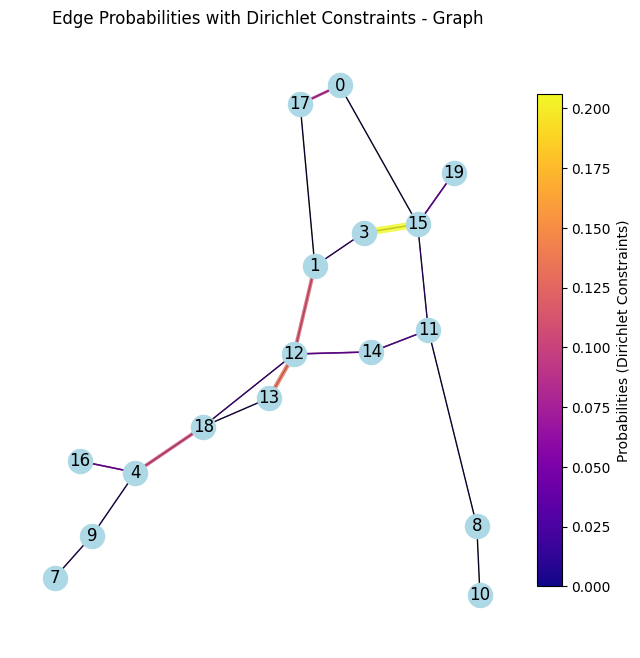

In [7]:
sim = TruckRoutingSimulationFromCSV("graph.csv", "simulations.csv")
sim.run()


# Temporal windows 

In [8]:
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import numpy as np
from datetime import datetime

class TruckRoutingSimulationFromCSV:
    def __init__(self, graph_csv, simulation_csv, dirichlet_alpha=1e-5):
        self.graph_csv = graph_csv
        self.simulation_csv = simulation_csv
        self.alpha = dirichlet_alpha
        self.G = None
        self.edge_probabilities = None
        self.simulation_data = None
        self.edge_constraints = {}

    def load_graph_from_csv(self):
        """Loads the graph from a CSV file containing edges and their weights, and adds inverse edges to make it bidirectional."""
        data = pd.read_csv(self.graph_csv)
        data['source'] = data['source'].astype(int)
        data['target'] = data['target'].astype(int)
        data['weight'] = data['weight'].astype(int)
        self.G = nx.Graph()

        # Add edges and make the graph bidirectional
        for _, row in data.iterrows():
            source = row['source']
            target = row['target']
            weight = row['weight']
            self.G.add_edge(source, target, weight=weight)

            # Add the inverse edge for bidirectionality
            if not self.G.has_edge(target, source):
                self.G.add_edge(target, source, weight=weight)

        print(f"Graph loaded with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges.")

    def load_simulation_data(self, simulation_file="simulations.csv"):
        """Loads simulation data from a CSV file and adds time window."""
        self.simulation_data = pd.read_csv(simulation_file)

        # Convert start and end times to datetime objects for easier manipulation
        self.simulation_data['start_time'] = pd.to_datetime(self.simulation_data['start_time'], format='%H:%M').dt.time
        self.simulation_data['end_time'] = pd.to_datetime(self.simulation_data['end_time'], format='%H:%M').dt.time

        # Filter to keep only valid nodes in the graph
        valid_nodes = set(self.G.nodes)
        self.simulation_data = self.simulation_data[
            (self.simulation_data['start_node'].isin(valid_nodes)) & 
            (self.simulation_data['end_node'].isin(valid_nodes))
        ]
        
        # Assign time windows to the simulations
        self.simulation_data['time_window'] = self.simulation_data['start_time'].apply(self.get_time_window)

        print(f"Simulations loaded from '{simulation_file}': {len(self.simulation_data)} valid.")

    def get_time_window(self, time):
        """Returns the time window based on the start time."""
        hour = time.hour
        return f"{hour:02d}:00 - {hour+1:02d}:00" if hour < 23 else "23:00 - 00:00"

    def simulate_truck_routes_from_csv(self):
        """Simulates truck routes hour by hour."""
        if not self.G:
            raise ValueError("Graph has not been loaded. Call load_graph_from_csv() first.")
        if self.simulation_data is None:
            raise ValueError("Simulation data has not been loaded. Call load_simulation_data() first.")

        # Initialize edge counts
        edge_counts = {tuple(sorted(edge)): 0 for edge in self.G.edges}

        # Process each time window
        for time_window in self.simulation_data['time_window'].unique():
            print(f"Simulating for time window: {time_window}...")

            # Filter the simulations for the current time window
            time_filtered_data = self.simulation_data[self.simulation_data['time_window'] == time_window]

            for _, row in time_filtered_data.iterrows():
                start_node = row['start_node']
                end_node = row['end_node']
                path = self.random_walk(start_node, end_node)

                for i in range(len(path) - 1):
                    edge = tuple(sorted((path[i], path[i + 1])))
                    if edge in edge_counts:
                        edge_counts[edge] += 1

        # Normalize the counts into probabilities
        self.edge_probabilities = {edge: count / len(self.simulation_data) for edge, count in edge_counts.items()}
        print("Simulation complete. Edge probabilities calculated.")

    def random_walk(self, start_node, end_node, max_steps=50):
        """Performs a random walk between start_node and end_node."""
        path = [start_node]
        current_node = start_node
        steps = 0

        while current_node != end_node and steps < max_steps:
            neighbors = list(self.G.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            path.append(next_node)
            current_node = next_node
            steps += 1

        return path

    def apply_constraints_with_time_window(self, alpha_capacities=1.0, alpha_costs=1.0, alpha_time=1.0):
        """Applies Dirichlet distribution to edge probabilities based on time window constraints."""
        if not self.edge_probabilities:
            raise ValueError("Edge probabilities have not been calculated.")

        # Example: Define different constraints for different time windows
        for time_window in self.simulation_data['time_window'].unique():
            print(f"Applying constraints for time window: {time_window}...")

            # Define constraints (random for illustration purposes)
            edge_constraints = self.get_time_window_constraints(time_window)

            # Apply Dirichlet distribution with time window-specific constraints
            capacities = np.array([edge_constraints[edge]["capacity"] for edge in self.G.edges])
            costs = np.array([1 / edge_constraints[edge]["cost"] for edge in self.G.edges])  # Inverse cost
            times = np.array([1 / edge_constraints[edge]["time"] for edge in self.G.edges])  # Inverse time

            dirichlet_capacities = dirichlet.rvs(capacities * alpha_capacities, size=1)[0]
            dirichlet_costs = dirichlet.rvs(costs * alpha_costs, size=1)[0]
            dirichlet_times = dirichlet.rvs(times * alpha_time, size=1)[0]

            final_probabilities = (dirichlet_capacities + dirichlet_costs + dirichlet_times) / 3
            self.edge_probabilities = {edge: prob for edge, prob in zip(self.G.edges, final_probabilities)}

    def get_time_window_constraints(self, time_window):
        """Return constraints based on the time window."""
        # Example: assign random constraints for each edge in the graph (for illustration)
        constraints = {
            edge: {
                "capacity": random.uniform(0.5, 1.0),  # Simulate capacity as a percentage
                "cost": random.uniform(1.0, 10.0),     # Simulate cost in arbitrary units
                "time": random.uniform(0.1, 2.0)       # Simulate time in arbitrary units
            }
            for edge in self.G.edges
        }
        return constraints

    def visualize_graph(self):
        """Visualizes the graph with edge probabilities."""
        if not self.edge_probabilities:
            raise ValueError("Edge probabilities have not been calculated.")

        pos = nx.spring_layout(self.G, seed=42)  # Layout for visualization
        probabilities = list(self.edge_probabilities.values())
        norm = plt.Normalize(vmin=0, vmax=max(probabilities))
        cmap = plt.cm.plasma

        fig, ax = plt.subplots(figsize=(8, 8))
        nx.draw(self.G, pos, with_labels=True, node_color="lightblue", node_size=300, ax=ax)

        for edge, prob in self.edge_probabilities.items():
            color = cmap(norm(prob))
            nx.draw_networkx_edges(
                self.G, pos, edgelist=[edge], width=5 * prob / max(probabilities), edge_color=[color], alpha=0.8, ax=ax
            )

        edge_labels = {edge: f"{prob:.4f}" for edge, prob in self.edge_probabilities.items()}
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Allow the colorbar to function properly
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
        cbar.set_label("Probabilities (Dirichlet Constraints)")
        ax.set_title("Edge Probabilities with Time Window Constraints")
        plt.show()

    def run(self):
        """Runs the full simulation."""
        self.load_graph_from_csv()
        self.load_simulation_data()
        self.simulate_truck_routes_from_csv()
        self.apply_constraints_with_time_window(alpha_capacities=2.0, alpha_costs=0.5, alpha_time=1.0)
        self.visualize_graph()


In [28]:
import random
import pandas as pd

def generate_graph_csv(filename, num_nodes=10, num_edges=20):
    edges = []
    # Étape 1 : Créer une base pour connecter tous les nœuds (graphe connexe)
    for i in range(num_nodes - 1):
        source = i
        target = i + 1
        edges.append({"source": source, "target": target, "weight": random.randint(1, 10)})

    # Étape 2 : Ajouter des arêtes supplémentaires pour atteindre le nombre demandé
    additional_edges = num_edges - len(edges)
    while additional_edges > 0:
        source = random.randint(0, num_nodes - 1)
        target = random.randint(0, num_nodes - 1)
        while source == target or {"source": source, "target": target} in edges or {"source": target, "target": source} in edges:
            target = random.randint(0, num_nodes - 1)
        edges.append({"source": source, "target": target, "weight": random.randint(1, 10)})
        additional_edges -= 1

    # Convertir en DataFrame et sauvegarder dans un fichier CSV
    df = pd.DataFrame(edges)
    df.to_csv(filename, index=False)
    print(f"Connected Graph CSV generated: {filename}")
    
from datetime import timedelta, time

def generate_simulation_csv(filename, num_simulations=1000, num_nodes=10, start_hour=8, end_hour=18):
    simulations = []
    for _ in range(num_simulations):
        start_node = random.randint(0, num_nodes - 1)
        end_node = random.randint(0, num_nodes - 1)
        while start_node == end_node:
            end_node = random.randint(0, num_nodes - 1)
        
        # Générer un horaire de début et de fin aléatoires dans la plage de 8h à 18h
        start_time = time(random.randint(start_hour, end_hour), random.randint(0, 59))
        end_time = time(random.randint(start_hour, end_hour), random.randint(0, 59))
        
        # S'assurer que l'heure de fin est après l'heure de début
        if end_time <= start_time:
            end_time = time((start_time.hour + 1) % 24, start_time.minute)

        simulations.append({
            "start_node": start_node, 
            "end_node": end_node, 
            "start_time": start_time.strftime('%H:%M'),  # Format time as string
            "end_time": end_time.strftime('%H:%M')
        })

    df = pd.DataFrame(simulations)
    df.to_csv(filename, index=False)
    print(f"Simulation CSV generated: {filename}")


Graph CSV generated: graph_data.csv
Simulation CSV generated: simulations.csv
Graph loaded with 9 nodes and 18 edges.
Simulations loaded from 'simulations.csv': 71 valid.
Simulating for time window: 14:00 - 15:00...
Simulating for time window: 11:00 - 12:00...
Simulating for time window: 10:00 - 11:00...
Simulating for time window: 12:00 - 13:00...
Simulating for time window: 18:00 - 19:00...
Simulating for time window: 17:00 - 18:00...
Simulating for time window: 08:00 - 09:00...
Simulating for time window: 16:00 - 17:00...
Simulating for time window: 15:00 - 16:00...
Simulating for time window: 09:00 - 10:00...
Simulating for time window: 13:00 - 14:00...
Simulation complete. Edge probabilities calculated.
Applying constraints for time window: 14:00 - 15:00...
Applying constraints for time window: 11:00 - 12:00...
Applying constraints for time window: 10:00 - 11:00...
Applying constraints for time window: 12:00 - 13:00...
Applying constraints for time window: 18:00 - 19:00...
Applyin

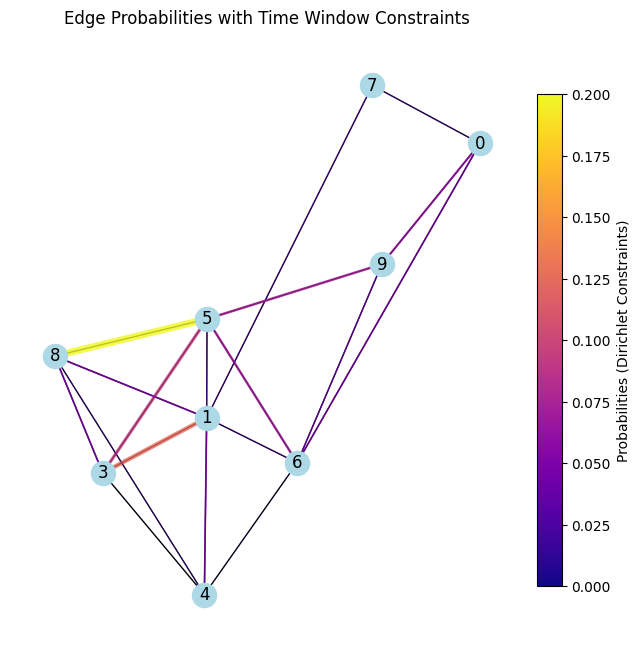

In [10]:
graph_csv = 'graph_data.csv'
simulation_csv = 'simulations.csv'

# Générer un graph avec 10 nœuds et 20 arêtes
generate_graph_csv(graph_csv, num_nodes=10, num_edges=20)

# Générer des simulations avec des fenêtres horaires entre 8h et 18h
generate_simulation_csv(simulation_csv, num_simulations=100, num_nodes=10, start_hour=8, end_hour=18)

# Créer une instance de la simulation avec ces fichiers CSV générés
simulation = TruckRoutingSimulationFromCSV(graph_csv, simulation_csv)

# Lancer la simulation
simulation.run()


In [ ]:
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
import numpy as np

class TruckRoutingSimulationFromCSV:
    def __init__(self, graph_csv, simulation_csv, dirichlet_alpha=1e-5):
        self.graph_csv = graph_csv
        self.simulation_csv = simulation_csv
        self.alpha = dirichlet_alpha
        self.G = None
        self.edge_probabilities_per_window = {}  # Temporal window
        self.simulation_data = None

    def load_graph_from_csv(self):
        """Loads the graph from a CSV file containing edges and their weights."""
        data = pd.read_csv(self.graph_csv)
        data['source'] = data['source'].astype(int)
        data['target'] = data['target'].astype(int)
        data['weight'] = data['weight'].astype(int)
        self.G = nx.Graph()

        for _, row in data.iterrows():
            source = row['source']
            target = row['target']
            weight = row['weight']
            self.G.add_edge(source, target, weight=weight)
            if not self.G.has_edge(target, source):
                self.G.add_edge(target, source, weight=weight)

        print(f"Graph loaded with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges.")

    def load_simulation_data(self):
        """Loads simulation data from a CSV file and assigns time windows."""
        self.simulation_data = pd.read_csv(self.simulation_csv)
        valid_nodes = set(self.G.nodes)

        # conversion in "datetime"
        self.simulation_data['start_time'] = pd.to_datetime(self.simulation_data['start_time'], format='%H:%M').dt.time
        self.simulation_data['end_time'] = pd.to_datetime(self.simulation_data['end_time'], format='%H:%M').dt.time

        # define temporal windows 
        def assign_time_window(start_time):
            hour = start_time.hour
            return f"{hour:02d}:00-{(hour + 1) % 24:02d}:00" #each hour

        self.simulation_data['time_window'] = self.simulation_data['start_time'].apply(assign_time_window)

        # Filter valid nodes in the graph
        initial_count = len(self.simulation_data)
        self.simulation_data = self.simulation_data[
            (self.simulation_data['start_node'].isin(valid_nodes)) & 
            (self.simulation_data['end_node'].isin(valid_nodes))
        ]
        filtered_count = len(self.simulation_data)

        print(f"Simulations loaded: {initial_count} initial, {filtered_count} valid.")

    def simulate_truck_routes_per_window(self):
        """Simulates truck routes and computes edge probabilities for each time window."""
        if not self.G:
            raise ValueError("The graph has not been loaded. Call load_graph_from_csv() first.")
        if self.simulation_data is None:
            raise ValueError("Simulation data has not been loaded. Call load_simulation_data() first.")

        unique_time_windows = self.simulation_data['time_window'].unique()
        for window in unique_time_windows:
            # Filter data for the current window
            window_data = self.simulation_data[self.simulation_data['time_window'] == window]
            edge_counts = {tuple(sorted(edge)): 0 for edge in self.G.edges}

            print(f"Simulating routes for time window {window}...")
            for _, row in window_data.iterrows():
                start_node = row['start_node']
                end_node = row['end_node']
                path = self.random_walk(start_node, end_node)

                for i in range(len(path) - 1):
                    edge = tuple(sorted((path[i], path[i + 1])))
                    if edge in edge_counts:
                        edge_counts[edge] += 1

            # Normalize edge probabilities for this window
            total_routes = len(window_data)
            edge_probabilities = {edge: count / total_routes for edge, count in edge_counts.items()}
            self.edge_probabilities_per_window[window] = edge_probabilities
        print("Simulation complete for all time windows.")

    def random_walk(self, start_node, end_node, max_steps=50):
        """Performs a random walk between start_node and end_node."""
        path = [start_node]
        current_node = start_node
        steps = 0

        while current_node != end_node and steps < max_steps:
            neighbors = list(self.G.neighbors(current_node))
            if not neighbors:
                break
            next_node = random.choice(neighbors)
            path.append(next_node)
            current_node = next_node
            steps += 1

        return path

    def apply_dirichlet_distribution_per_window(self):
        """Applies a Dirichlet distribution to edge probabilities for each time window."""
        if not self.edge_probabilities_per_window:
            raise ValueError("Edge probabilities have not been calculated.")
        
        for window, probabilities in self.edge_probabilities_per_window.items():
            alpha = np.array(list(probabilities.values())) + self.alpha
            dirichlet_sample = dirichlet.rvs(alpha, size=1)[0]
            self.edge_probabilities_per_window[window] = {
                edge: prob for edge, prob in zip(probabilities.keys(), dirichlet_sample)
            }
        print("Dirichlet distribution applied to edge probabilities for all time windows.")

    def get_restricted_edges(self, probability_threshold):
        """
        Returns restricted edges for each time window based on a probability threshold.
        
        Args:
        - probability_threshold (float): Threshold below which an edge is considered restricted.
        
        Returns:
        - restricted_edges_per_window (dict): Dictionary of restricted edges per time window.
        """
        if not self.edge_probabilities_per_window:
            raise ValueError("Edge probabilities have not been calculated.")

        restricted_edges_per_window = {}
        for window, probabilities in self.edge_probabilities_per_window.items():
            restricted_edges = [
                (int(edge[0]), int(edge[1])) for edge, prob in probabilities.items() if prob < probability_threshold
            ]
            restricted_edges_per_window[window] = restricted_edges

        return restricted_edges_per_window

    def visualize_graph_per_window(self):
        """Visualizes the graph with edge probabilities for each time window."""
        if not self.edge_probabilities_per_window:
            raise ValueError("Edge probabilities have not been calculated.")

        pos = nx.spring_layout(self.G, seed=42)
        cmap = plt.cm.plasma

        for window, probabilities in self.edge_probabilities_per_window.items():
            norm = plt.Normalize(vmin=0, vmax=max(probabilities.values()))

            fig, ax = plt.subplots(figsize=(12, 12))
            nx.draw(self.G, pos, with_labels=True, node_color="lightblue", node_size=300, ax=ax)

            for edge, prob in probabilities.items():
                color = cmap(norm(prob))
                nx.draw_networkx_edges(
                    self.G, pos, edgelist=[edge], width=5 * prob / max(probabilities.values()), edge_color=[color], alpha=0.8, ax=ax
                )

            edge_labels = {edge: f"{prob:.4f}" for edge, prob in probabilities.items()}
            nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
            cbar.set_label("Probabilities (Dirichlet Distribution)")
            ax.set_title(f"Edge Probabilities - Time Window: {window}")
            plt.show()

    def run(self):
        """Runs the full simulation."""
        self.load_graph_from_csv()
        self.load_simulation_data()
        self.simulate_truck_routes_per_window()
        self.apply_dirichlet_distribution_per_window()
        self.visualize_graph_per_window()

In [42]:
generate_graph_csv(graph_csv, num_nodes=10, num_edges=15)

# Générer des simulations avec des fenêtres horaires entre 8h et 18h
generate_simulation_csv(simulation_csv, num_simulations=1000, num_nodes=10, start_hour=0, end_hour=23)

Connected Graph CSV generated: graph_data.csv
Simulation CSV generated: simulations.csv


Graph loaded with 10 nodes and 13 edges.
Simulations loaded: 1000 initial, 1000 valid.
Simulating routes for time window 07:00-08:00...
Simulating routes for time window 04:00-05:00...
Simulating routes for time window 05:00-06:00...
Simulating routes for time window 15:00-16:00...
Simulating routes for time window 21:00-22:00...
Simulating routes for time window 02:00-03:00...
Simulating routes for time window 09:00-10:00...
Simulating routes for time window 18:00-19:00...
Simulating routes for time window 19:00-20:00...
Simulating routes for time window 14:00-15:00...
Simulating routes for time window 22:00-23:00...
Simulating routes for time window 16:00-17:00...
Simulating routes for time window 08:00-09:00...
Simulating routes for time window 13:00-14:00...
Simulating routes for time window 20:00-21:00...
Simulating routes for time window 01:00-02:00...
Simulating routes for time window 03:00-04:00...
Simulating routes for time window 11:00-12:00...
Simulating routes for time wind

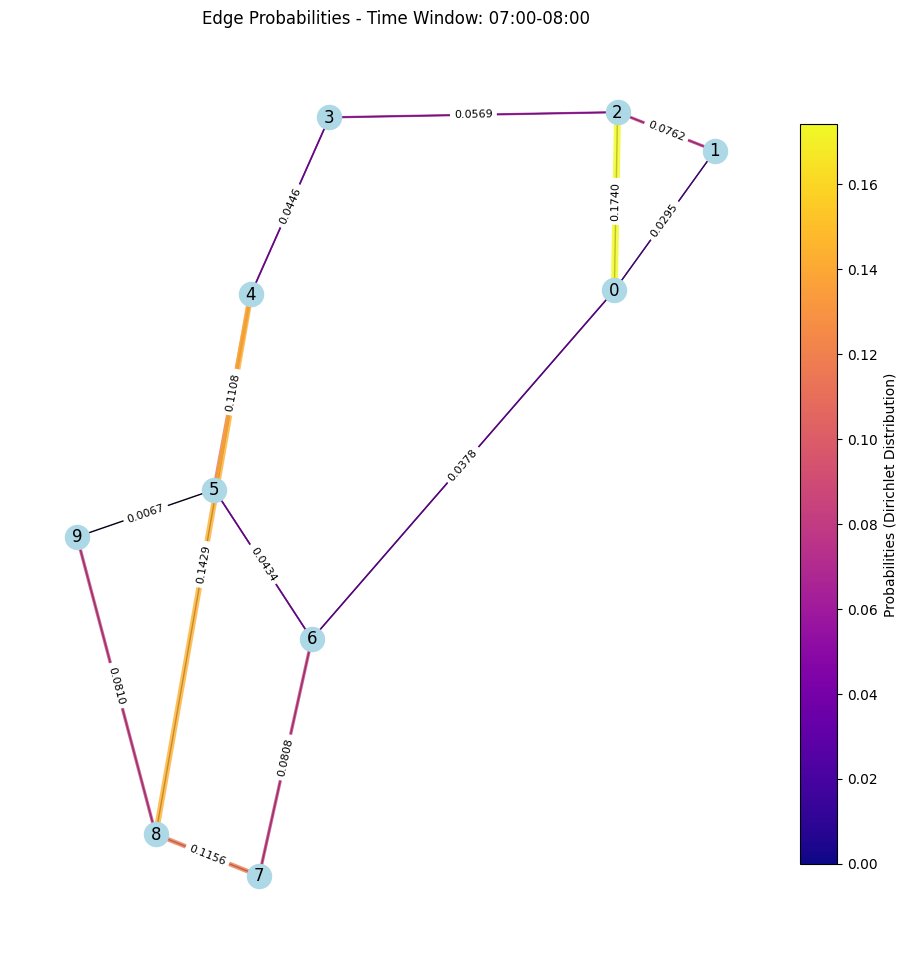

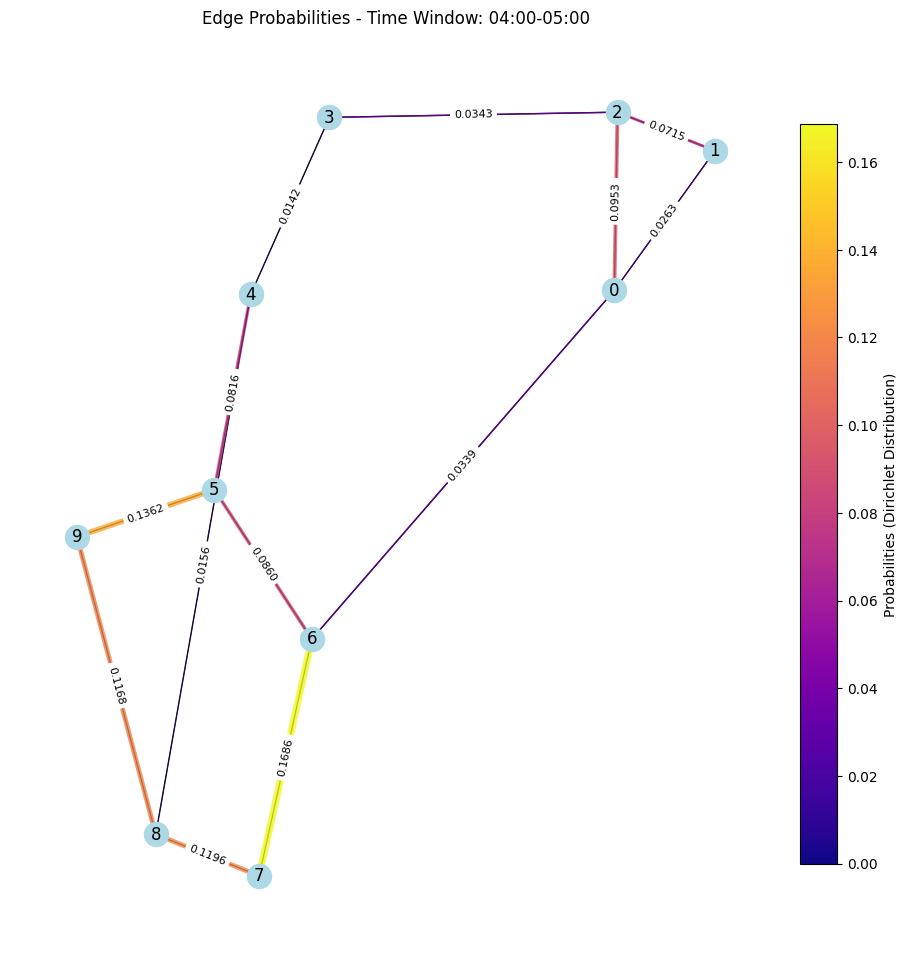

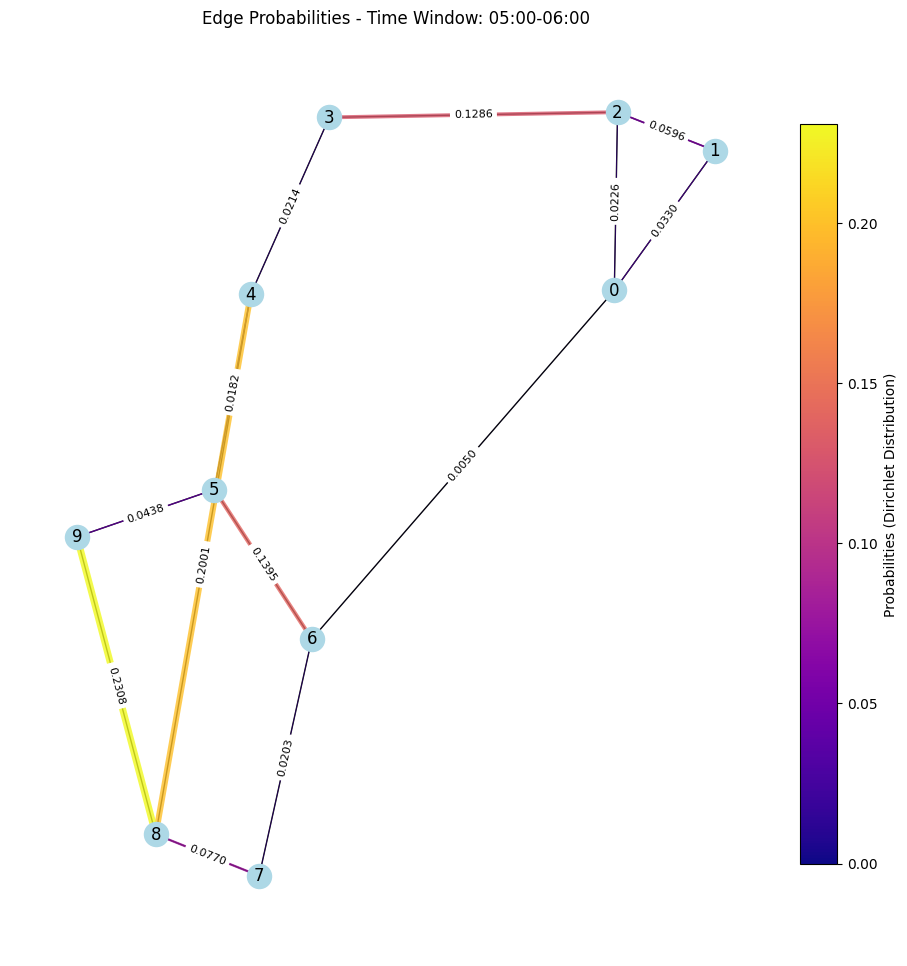

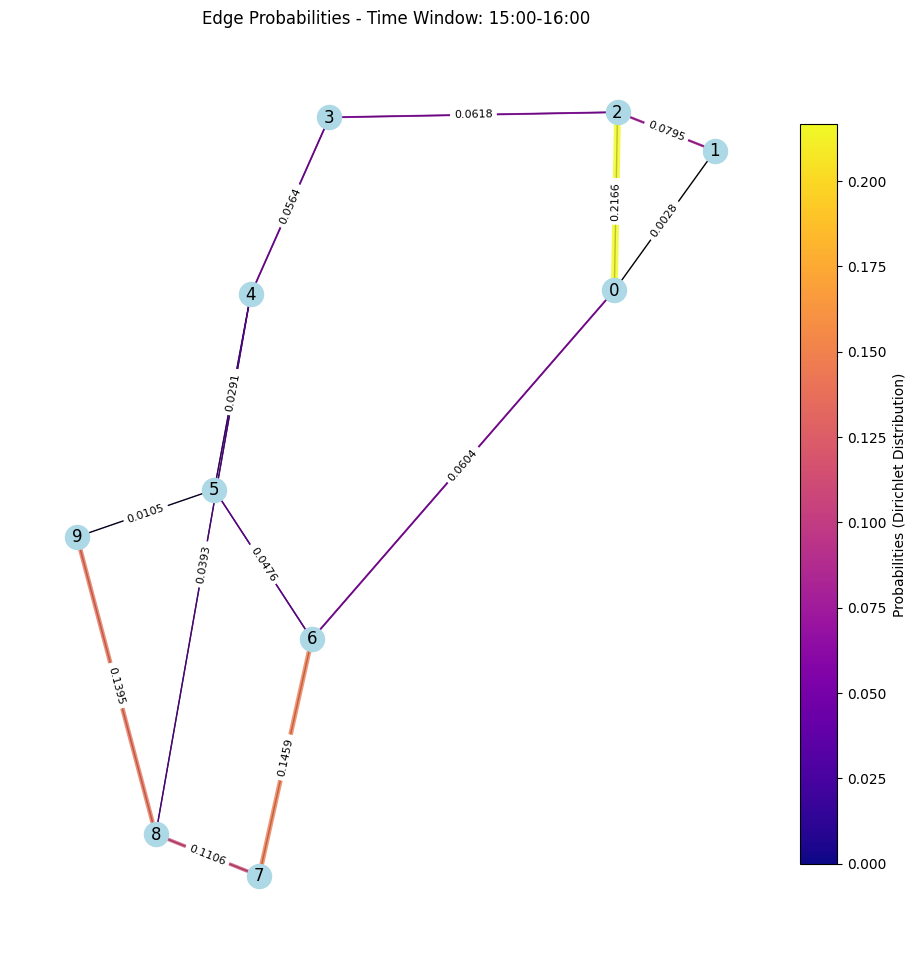

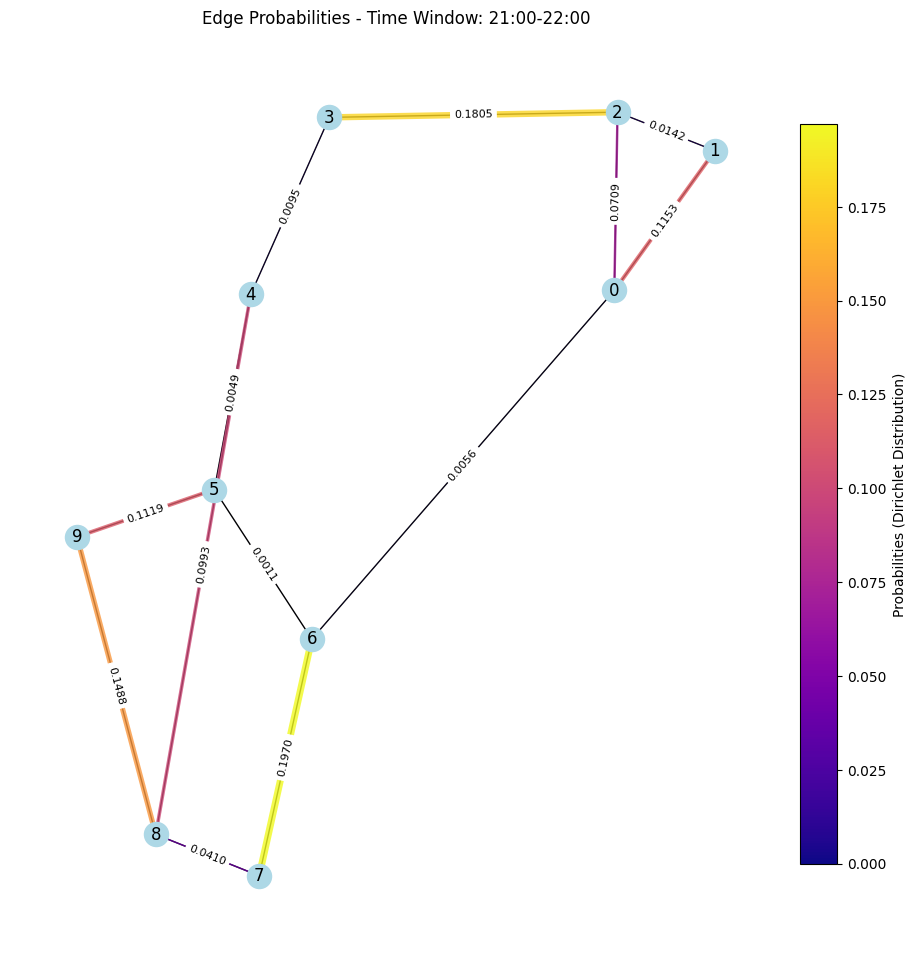

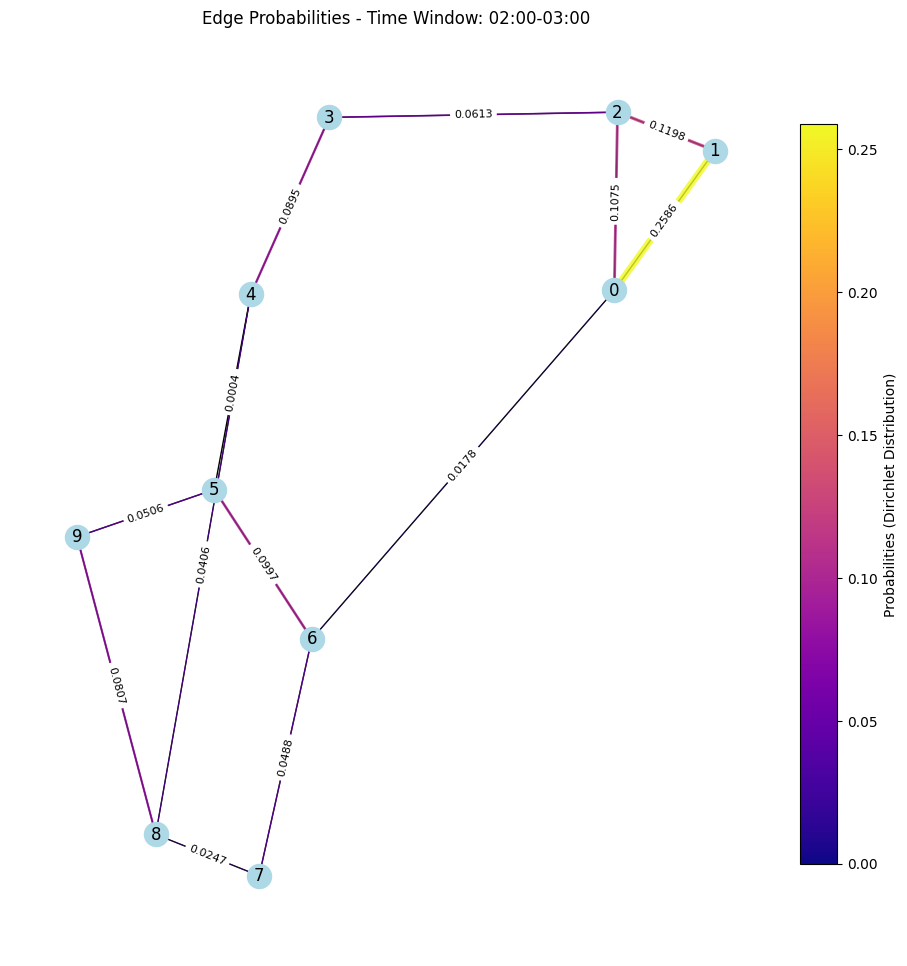

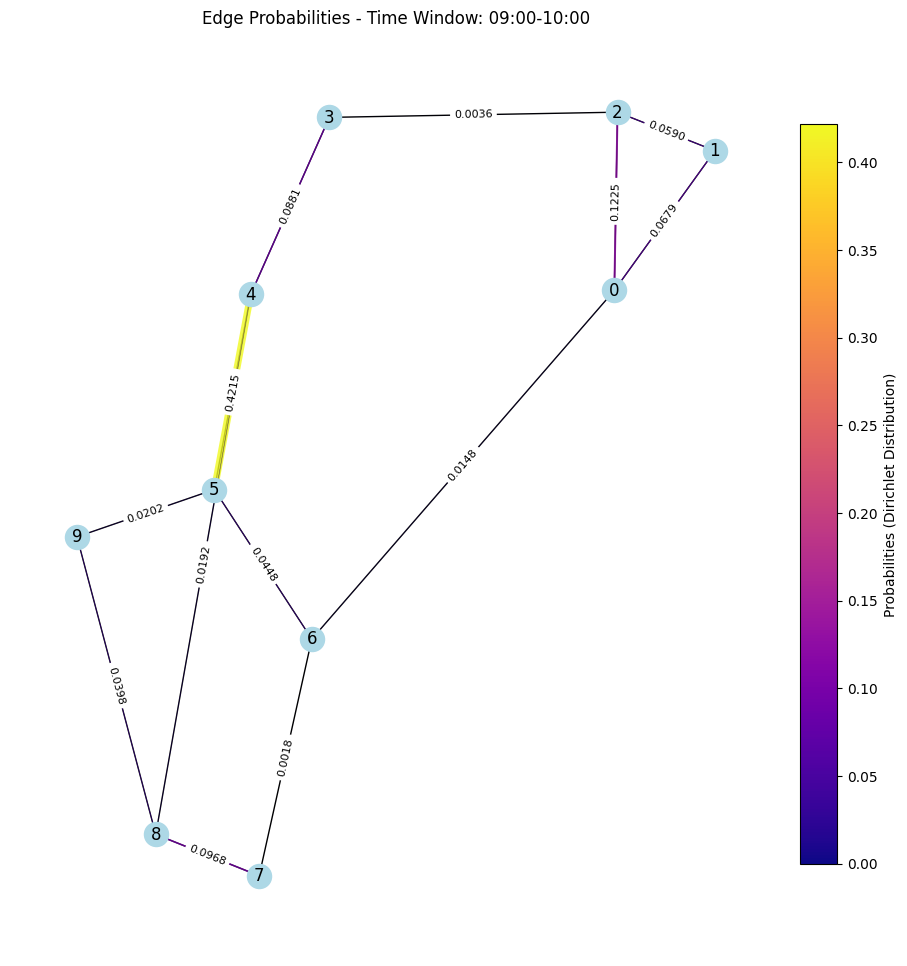

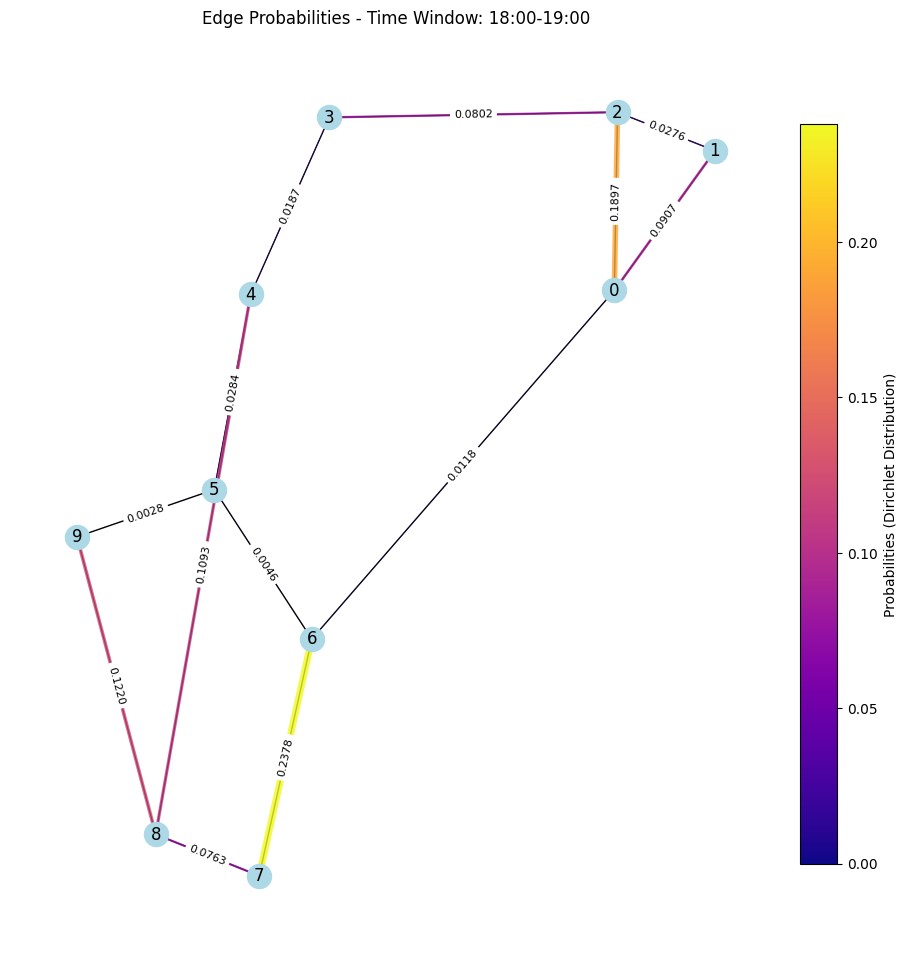

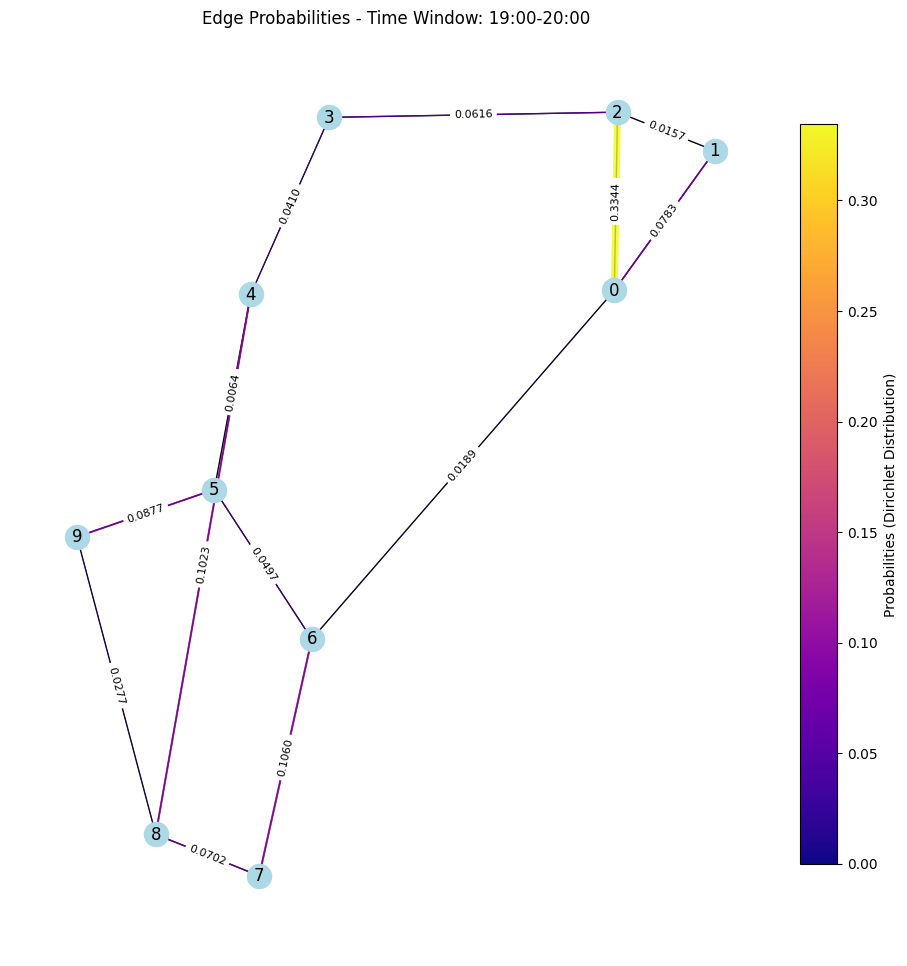

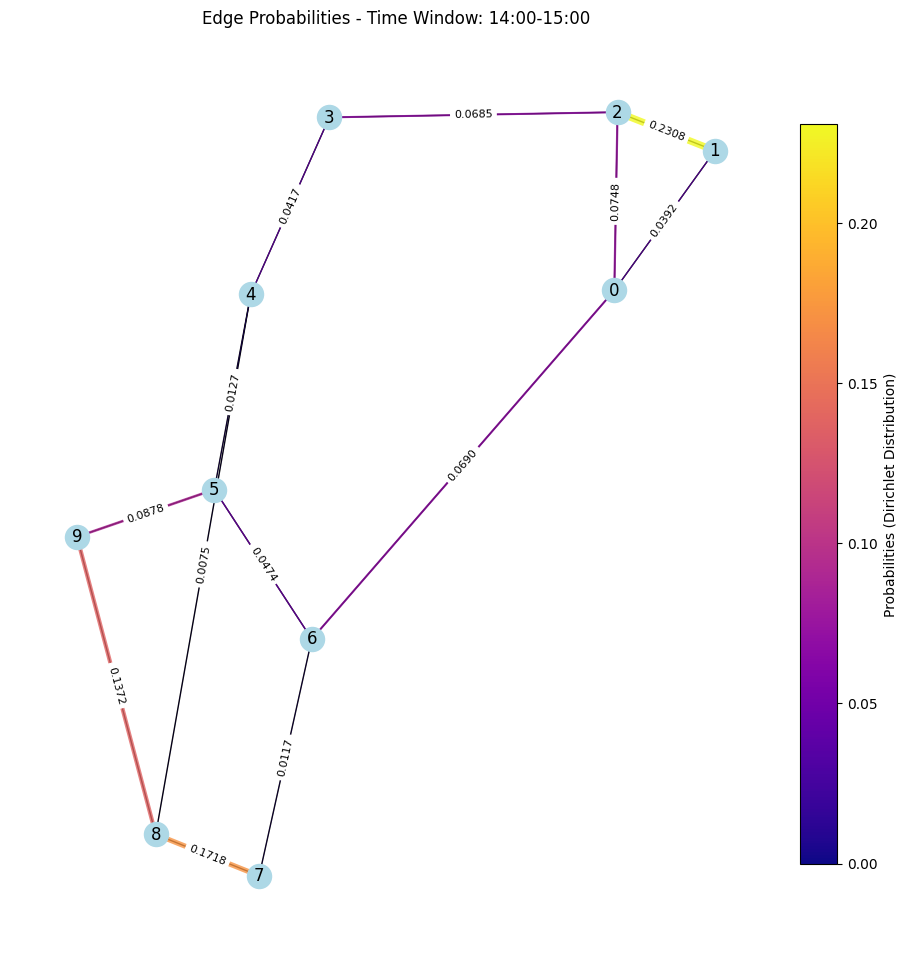

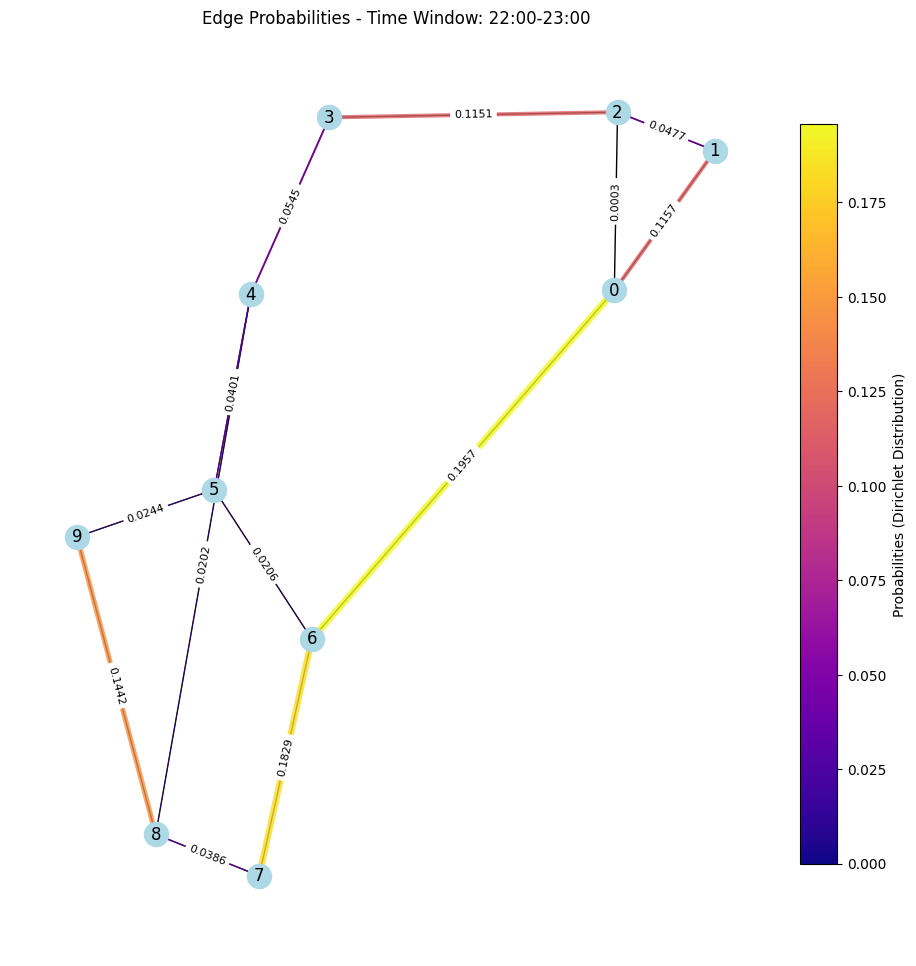

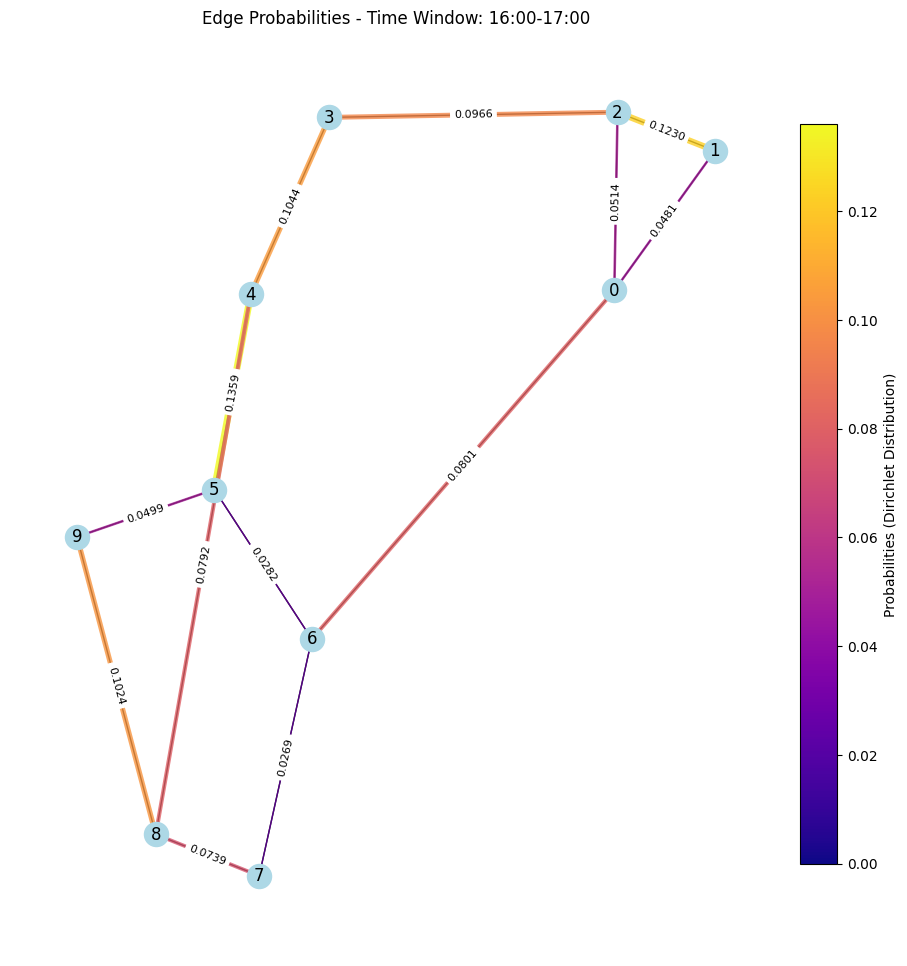

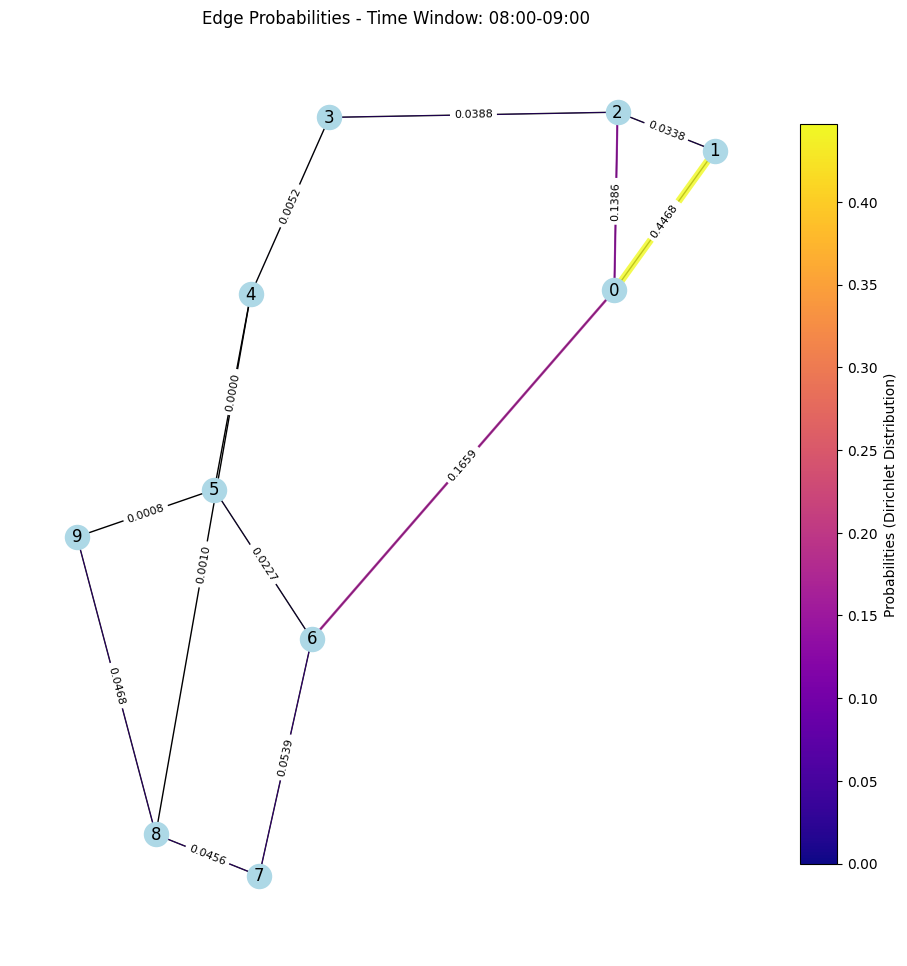

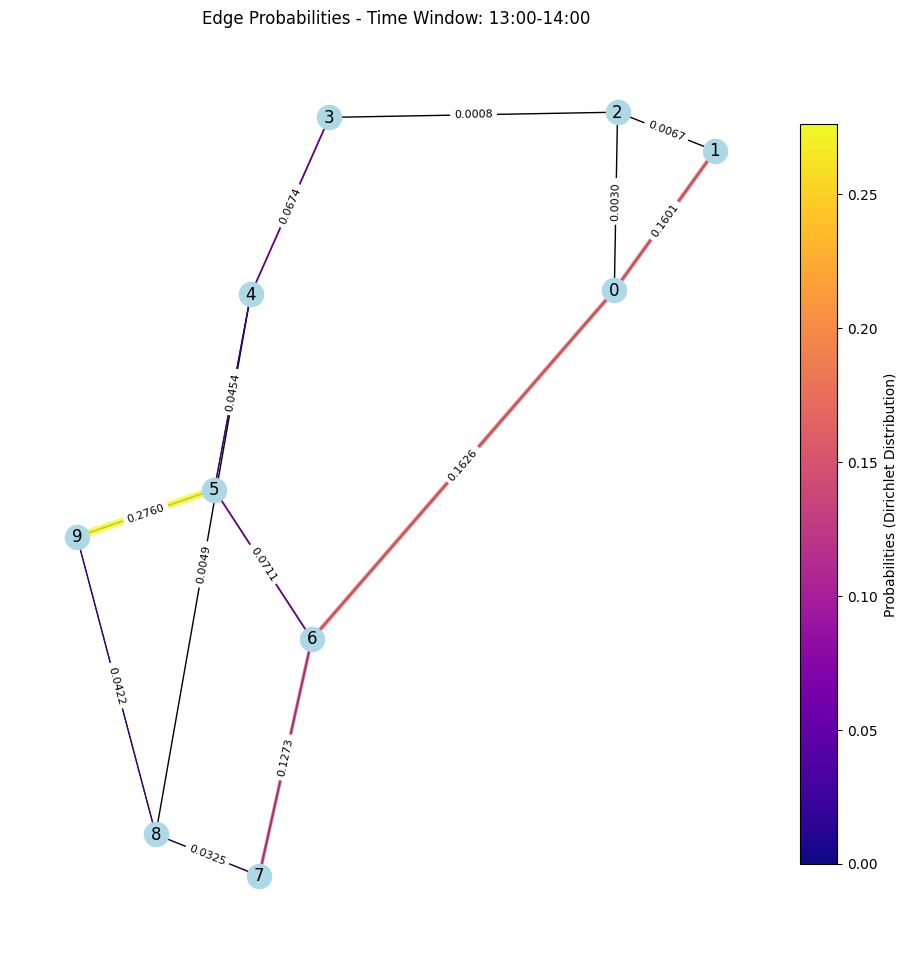

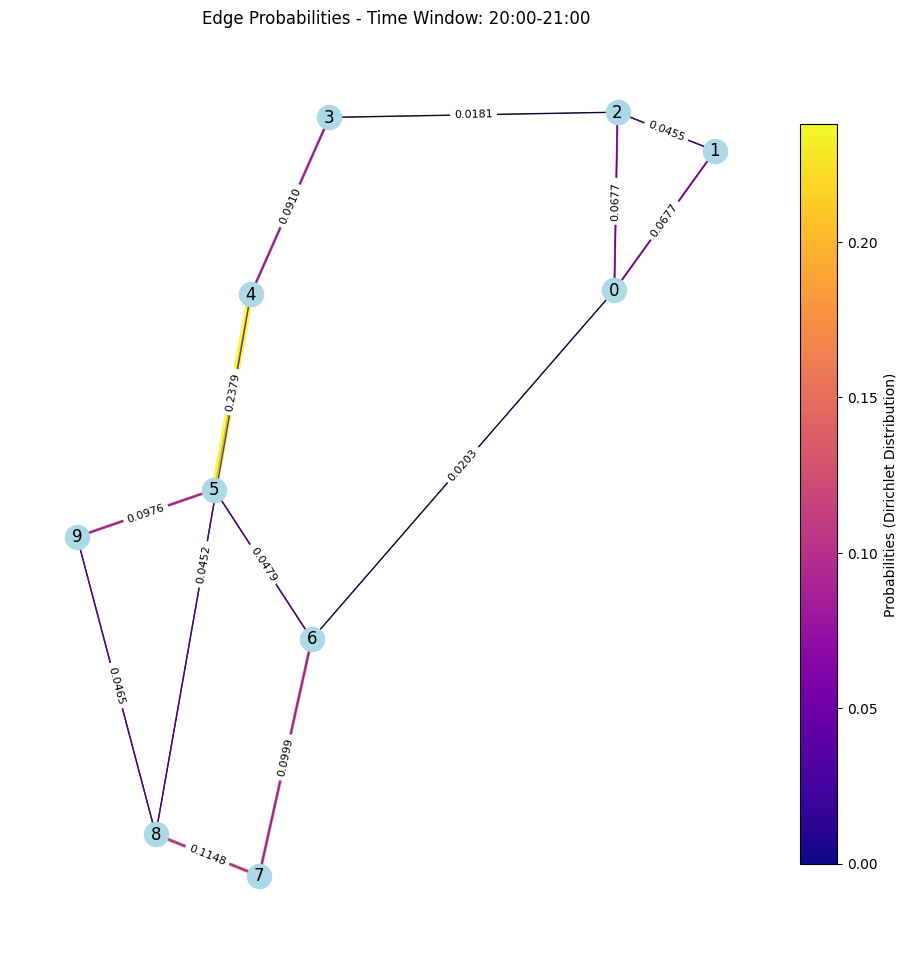

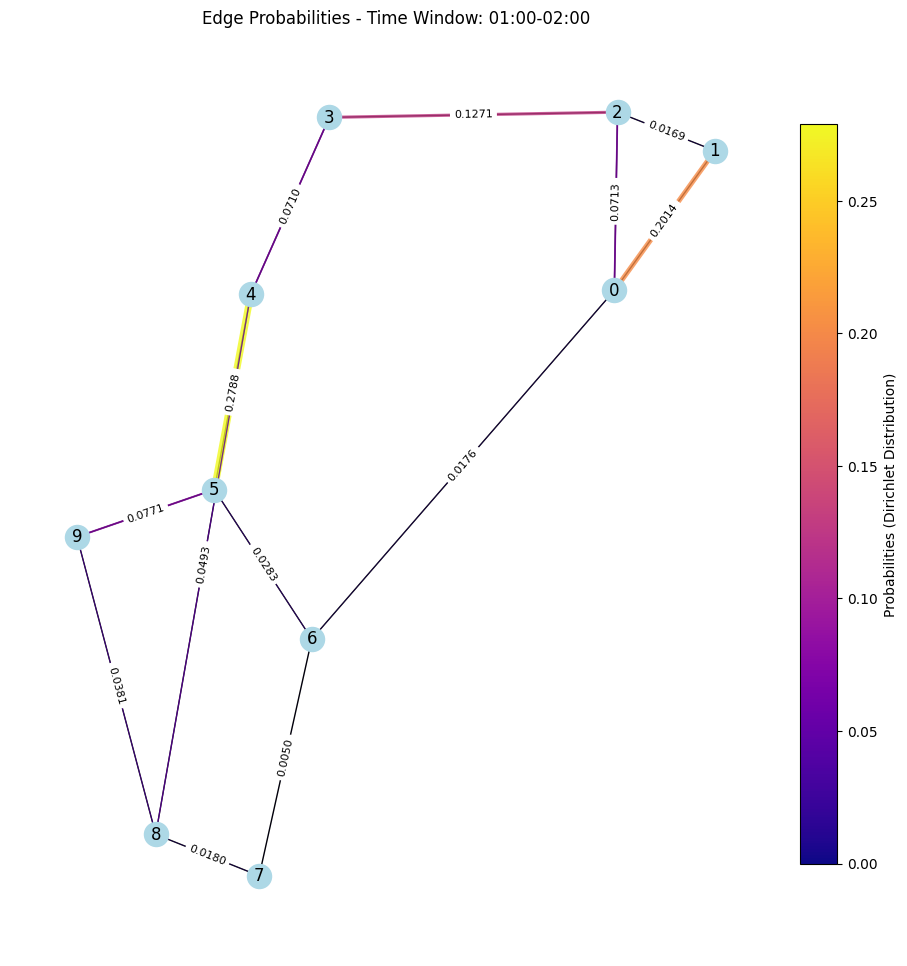

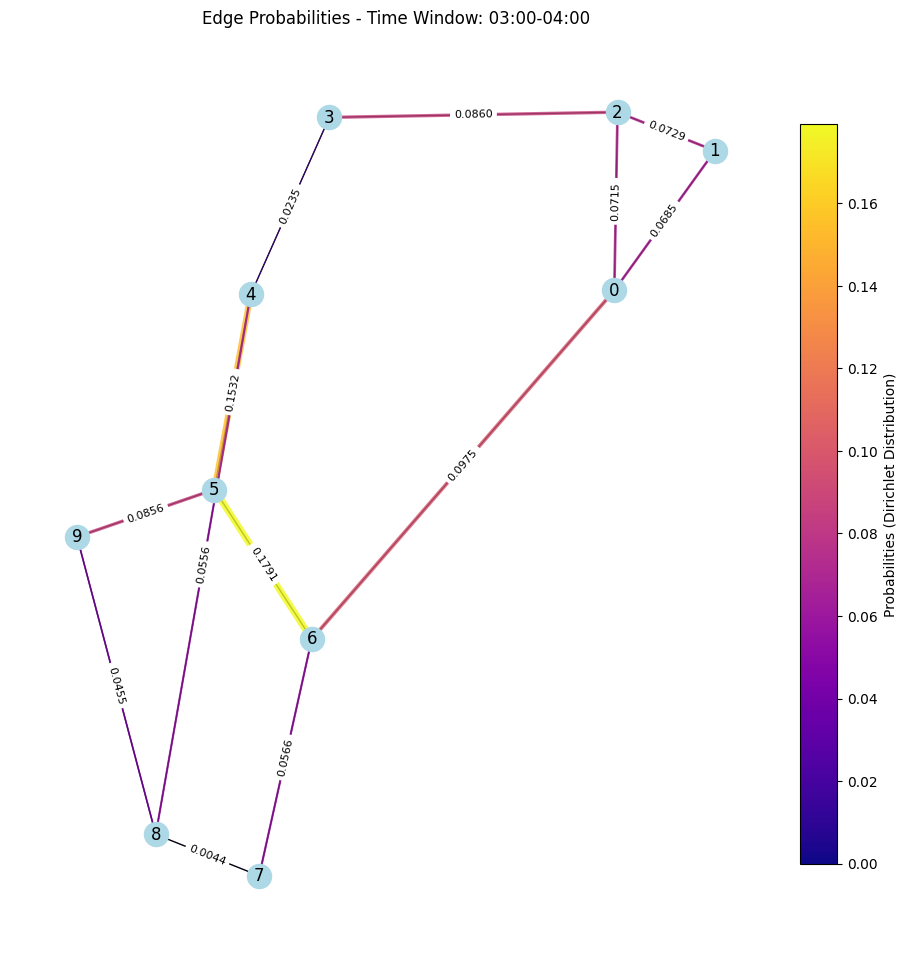

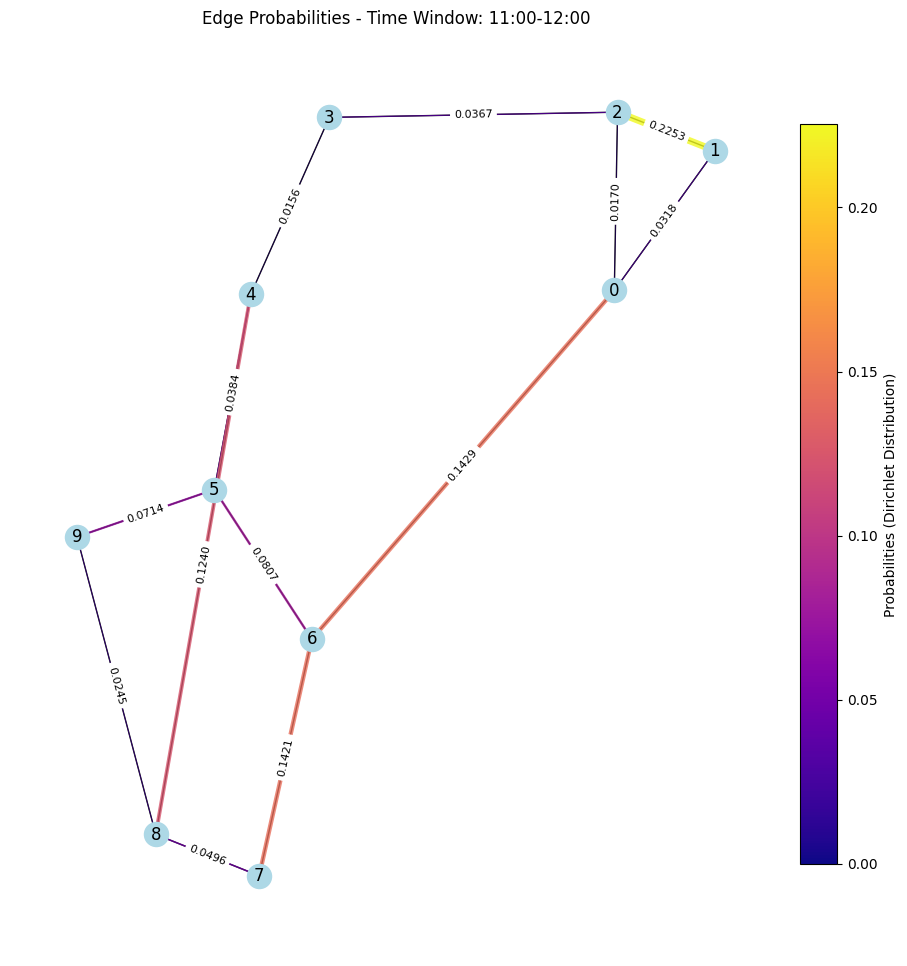

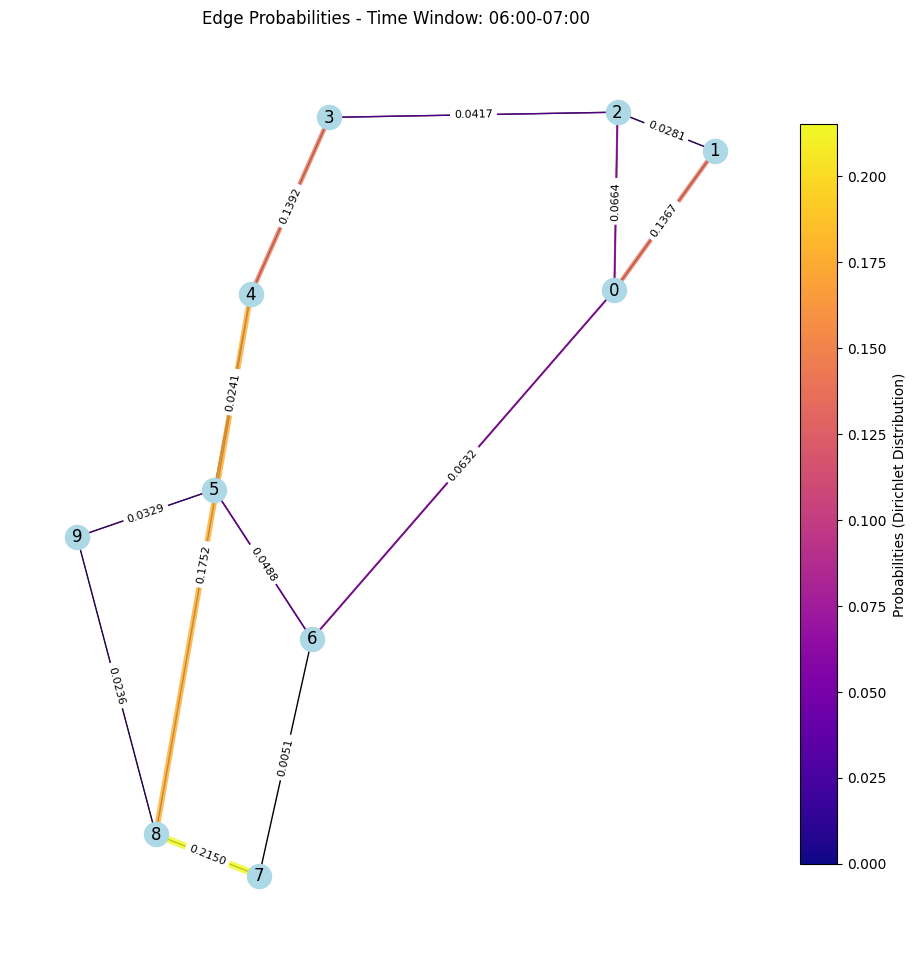

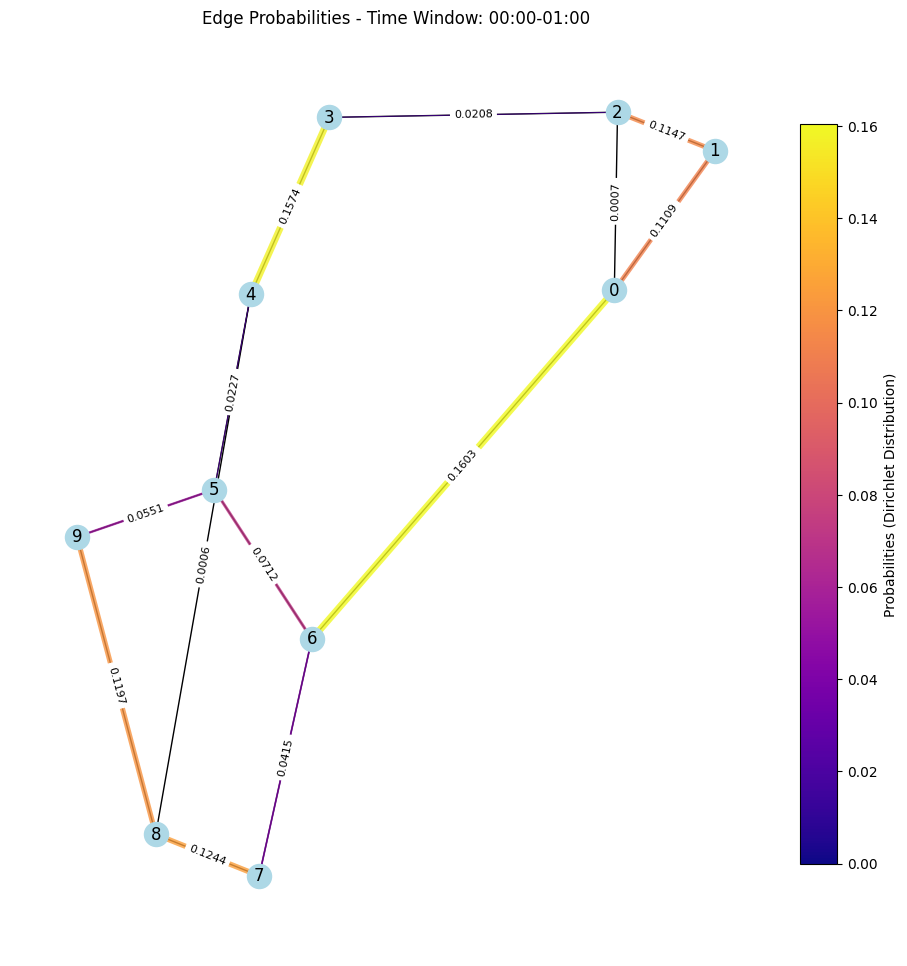

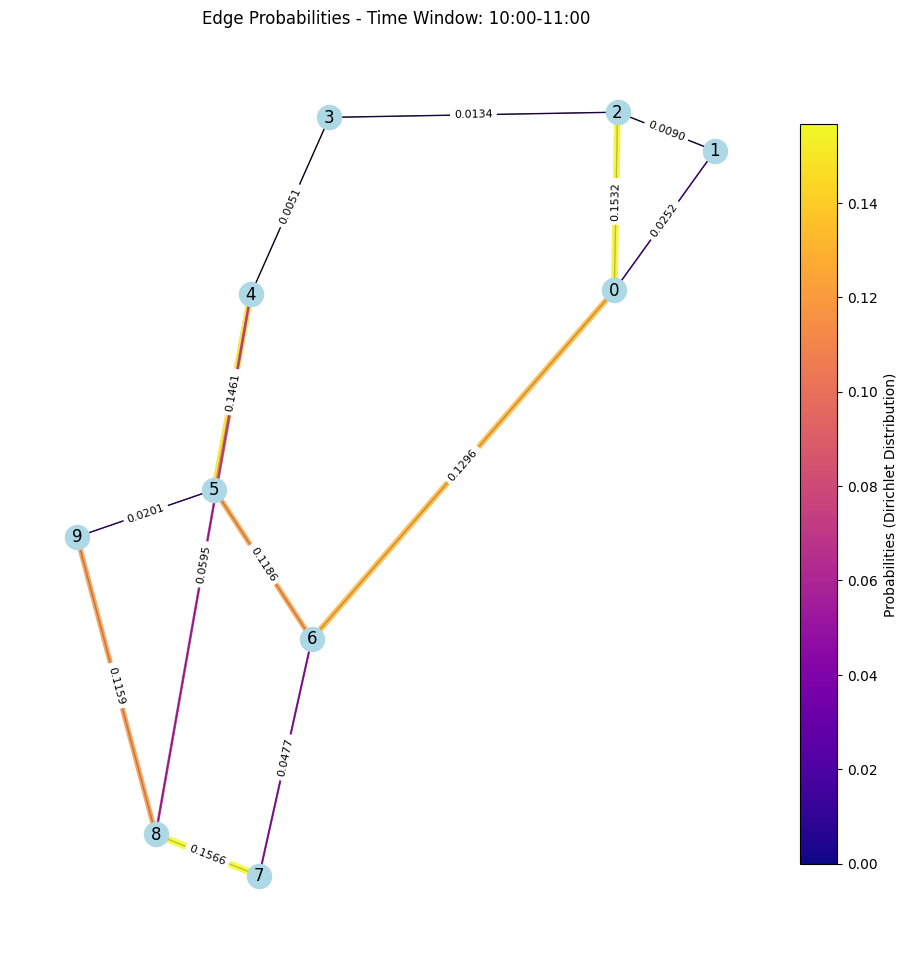

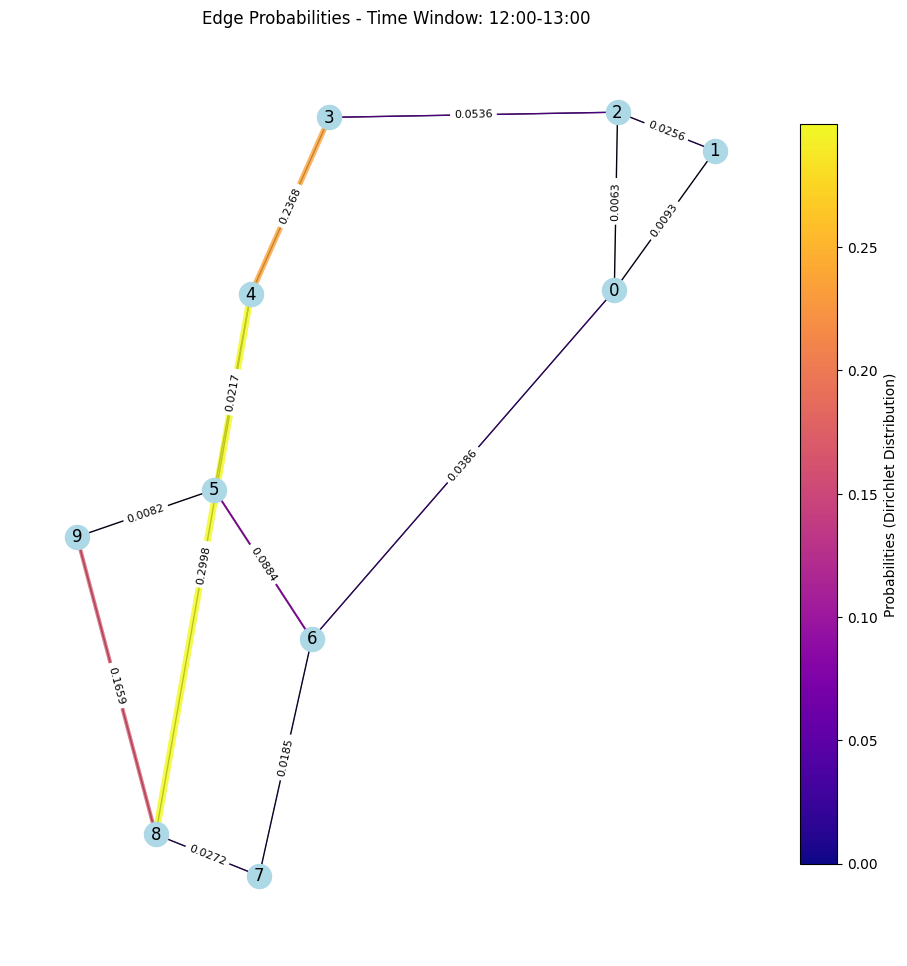

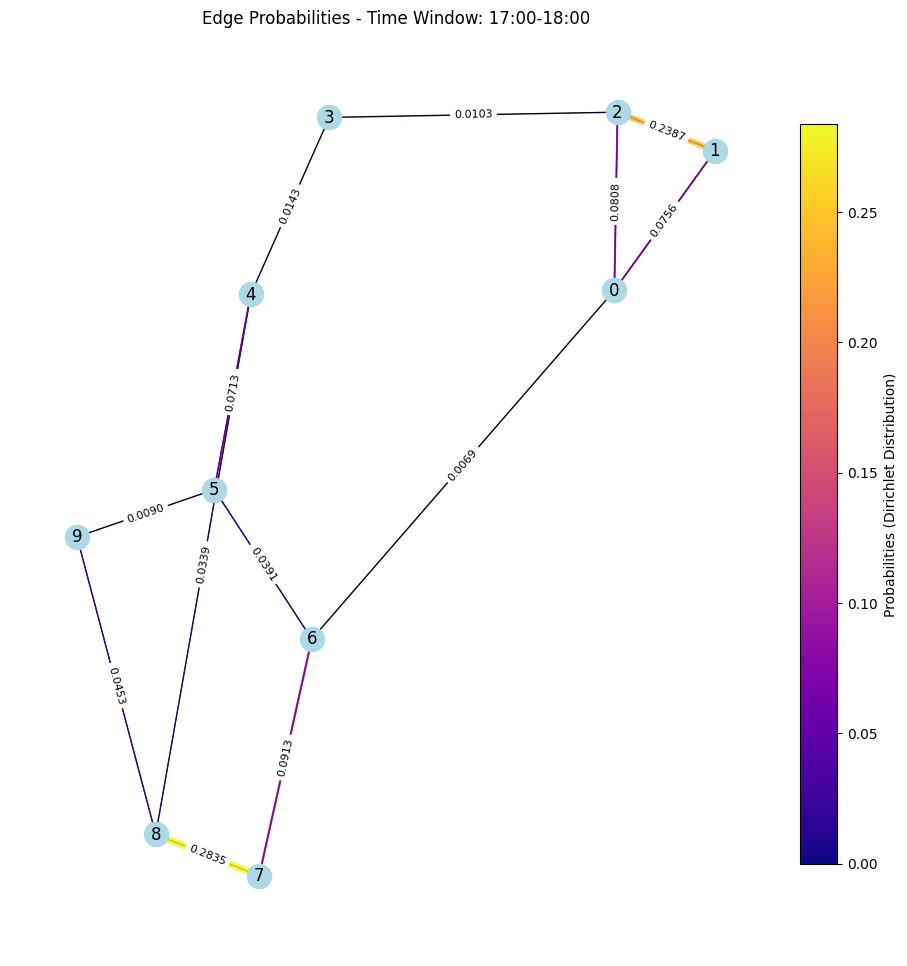

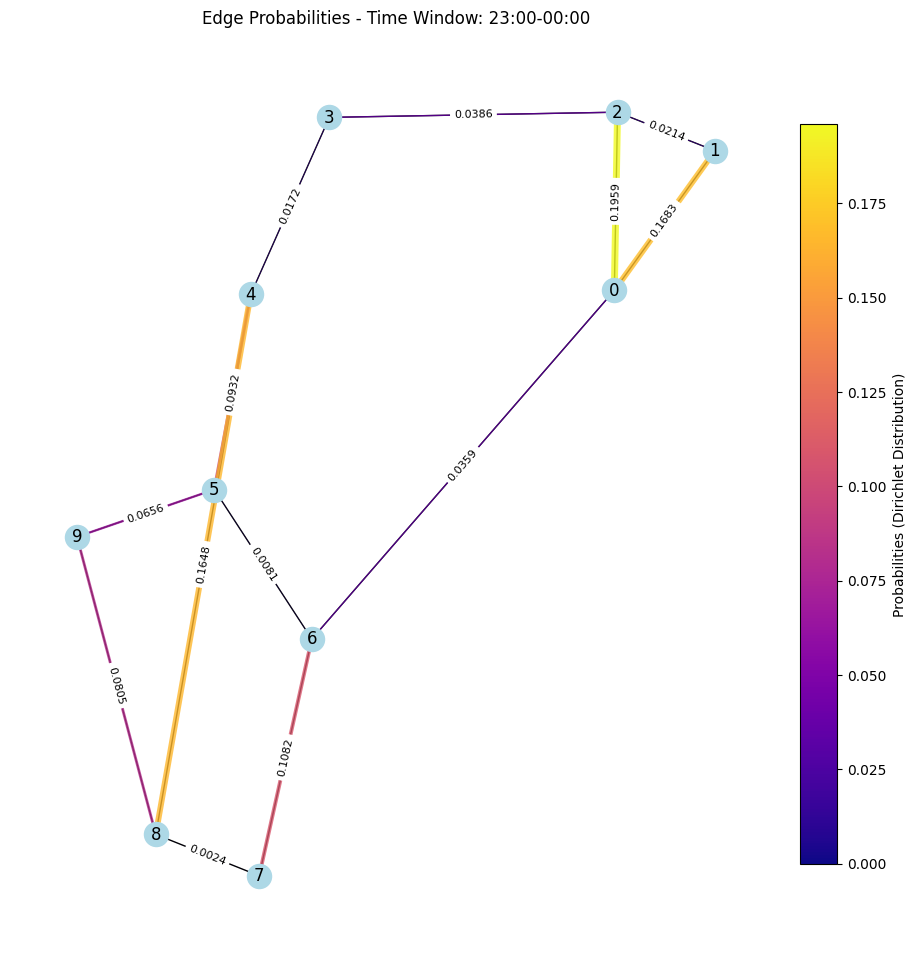

In [43]:
simulation = TruckRoutingSimulationFromCSV("graph_data.csv", "simulations.csv", dirichlet_alpha=1e-5)
simulation.run()


In [39]:
restricted_edges_per_window = simulation.get_restricted_edges(probability_threshold=0.0005)

# Chronological order
sorted_restricted_edges = dict(sorted(restricted_edges_per_window.items(), key=lambda x: x[0]))

for window, edges in sorted_restricted_edges.items():
    print(f"Time Window {window}: {edges}")

Time Window 00:00-01:00: [(7, 13)]
Time Window 01:00-02:00: [(7, 8)]
Time Window 02:00-03:00: []
Time Window 03:00-04:00: []
Time Window 04:00-05:00: []
Time Window 05:00-06:00: []
Time Window 06:00-07:00: []
Time Window 07:00-08:00: []
Time Window 08:00-09:00: []
Time Window 09:00-10:00: []
Time Window 10:00-11:00: [(5, 10)]
Time Window 11:00-12:00: [(2, 3)]
Time Window 12:00-13:00: []
Time Window 13:00-14:00: []
Time Window 14:00-15:00: []
Time Window 15:00-16:00: []
Time Window 16:00-17:00: []
Time Window 17:00-18:00: []
Time Window 18:00-19:00: []
Time Window 19:00-20:00: []
Time Window 20:00-21:00: [(11, 12)]
Time Window 21:00-22:00: [(5, 10)]
Time Window 22:00-23:00: [(2, 7)]
Time Window 23:00-00:00: []
